In [69]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point
import seaborn as sns
from matplotlib import cbook
import spvcm.api as spvcm 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In this notebook we generate $y_{rep}$ for the spatial hierarchical models to check for any systematic discrepancies between the real data and data simulated under the model.

In [70]:
# path = '/media/sam/sam_hdd/manchester_case_study/'
path = 'c:/Users/sgscombe/Documents/manchester_case_study/'

# read manchester shapefile and ldc stores 
manc = gpd.read_file(path+'manchester_catchments.shp')

ldc_data = pd.read_csv(path + '/data/modelling_hsar.csv')
ldc_data = ldc_data[ldc_data['PremiseStatus'] == 'Live'] 

# convert to geopandas
geometry = [Point(xy) for xy in zip(ldc_data['Geocode Easting'].astype(float), ldc_data['Geocode Northing'].astype(float))]
ldc_data_gpd = gpd.GeoDataFrame(ldc_data, crs=manc.crs, geometry=geometry)
ldc_data = sjoin(ldc_data_gpd.drop('index_right', axis=1), manc[['geometry']], op='within')

# keep only intersecting catchments
catchments = gpd.read_file(path+'shps/m_weights.shp')
catchments = catchments[catchments.cluster_id.isin(ldc_data.cluster_id.tolist())] 
catchments = catchments.drop_duplicates(subset='cluster_id')
catchments = catchments.set_index('cluster_id').sort_index()

# build lower-level design matrix
dummies_store_category = pd.get_dummies(ldc_data.cat_Name1).columns # store categories
ldc_data = ldc_data.merge(pd.get_dummies(ldc_data.cat_Name1), left_index=True, right_index=True)
ldc_data = ldc_data.sort_values('cluster_id') 
features_store_category = dummies_store_category.tolist()
features_store_category.remove('Showrooms') # drop reference dummies
features = list(cbook.flatten(['no_rooms', 'total_area', 'car_park_spaces', 
                               features_store_category]))

# use gravity weights to define neighbours
m = ps.weights.DistanceBand.from_dataframe(catchments,
                                           threshold=5000,  # inferred from variogram
                                           binary=False,
                                           alpha = -2.0);

# lower-level design matrix
X = ldc_data[features].values 
# observations
N = X.shape[0]
# higher-level design matrix
Z = np.eye(catchments.shape[0])
# regions
J = Z.shape[0]
# response
Y = ldc_data.total_value.values.reshape(-1, 1)
Y = np.log(Y)

Next we define $\Delta$ which captures the nesting of store premises into town centre boundaries.

In [11]:
# N x J
membership = ldc_data.cluster_id.apply(lambda x: m.id_order.index(x)).values

Delta = np.zeros((N, J))
for idx, region in enumerate(np.unique(membership)):
    Delta[membership.flatten() == region, idx] = 1

Now we run the samplers for 20000 iterations using a single chain.

In [53]:
sese = spvcm.upper.SE(Y, X,M=m, membership=membership, extra_traced_params=['XBetas'],
                         n_samples=20000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01));

upper_sma = spvcm.upper.SMA(Y,X,M=m, membership=membership, extra_traced_params=['XBetas'],
                         n_samples=20000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01), verbose=True);

In [55]:
se = sese.trace.to_df()
sma = upper_sma.trace.to_df()

Our outcome variable $y_{rep}$ is generated by sampling from the normal distribution. In our case, we relax the standard multilevel model assumption of independent random regional effects $\theta$, allowing for $\theta_j$ to be more similar to neigbouring geographies.

$$
    Y = X\beta + \Delta \theta + \epsilon, \; \epsilon \sim \mathcal{N}(0, \sigma_e^2) \\
    \theta = \lambda M\theta + u, \: u \sim \mathcal{N}(0, \sigma_u^2)\\
    \theta = (I - \lambda M)^{-1}u
$$

where $\Delta$ provides the identity of observations to their respective town centre boundary and relates $\theta$ to the correct lower level unit. 

As we specify a spatial process at the upper level only, we generate a $y_{rep}$  from the parameters of our posterior distribution once convergence has been met.  Essentially, this means that at each additional step of the MCMC chain (post-convergence), we use the parameter values ($\sigma_2^e, \theta, X\beta$) to randomly generate a simulated datum $y_{rep}$, followed by an examination of the resulting posterior predictive distribution.

Let's quickly check the trace plots to decide whether our chain has converged.

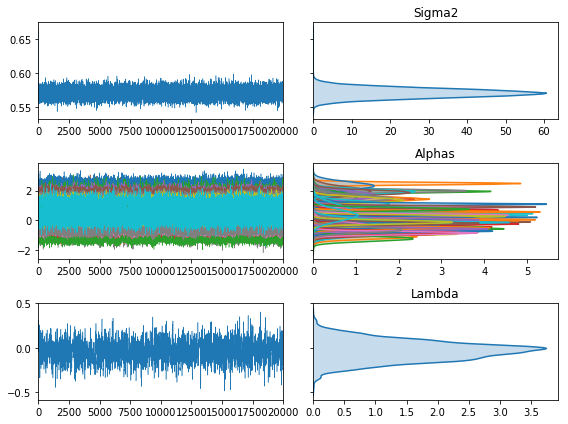

In [56]:
sese.trace.plot(varnames=['Sigma2', 'Alphas', 'Lambda']);

In [63]:
spvcm.diagnostics.point_estimates(sese)[0]['Lambda']

-0.035842580078242231

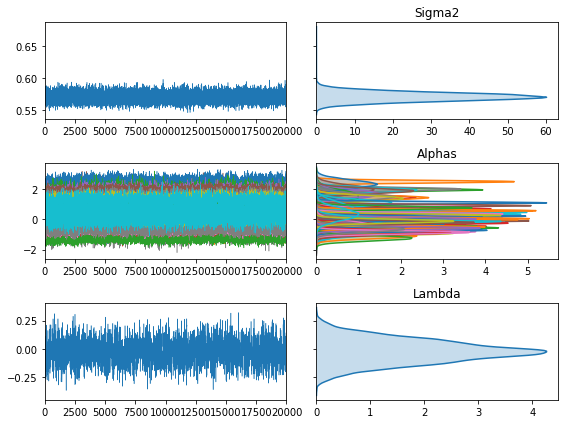

In [57]:
upper_sma.trace.plot(varnames=['Sigma2', 'Alphas', 'Lambda']);

In [64]:
spvcm.diagnostics.point_estimates(upper_sma)[0]['Lambda']

-0.025716990596569039

The trace plots reveal that, generally, the chain has converged meaning we can now proceed to use the parameter values of the posterior distribution to simulation $y_{rep}$.

In [68]:
def draw_y_reps(db, data, n_reps):

    db = db.iloc[1000:].sample(n_reps) # burnin first 1,000

    result = np.empty(len(db), dtype=object)

    for i, draw in enumerate(db.iterrows()): 
        
        # extract parameters from posterior
        sigma2 = draw[1]['Sigma2']

        alphas = draw[1].to_frame().T.filter(regex='Alpha').values[0]
        
        Delta_alphas = np.dot(Delta, alphas)

        XBs = draw[1].to_frame().T.filter(regex='XBeta').values[0]

        y_reps = np.random.normal(XBs + Delta_alphas, sigma2)

        result[i] = np.array(y_reps)
        
    return result

n_reps = 500

results_se = draw_y_reps(se, ldc_data, n_reps)
results_sma = draw_y_reps(sma, ldc_data, n_reps)

In [66]:
%%capture
from matplotlib.patches import Rectangle

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for res in results_se:
    sns.kdeplot(res, ax=ax1, alpha=.2, color='#cce5ff', legend=True)

sns.kdeplot(np.log(ldc_data['total_value']), ax=ax1, color='#333399', legend=False)

for res in results_sma:
    sns.kdeplot(res, ax=ax2, alpha=.2, color='#cce5ff', legend=True)

sns.kdeplot(np.log(ldc_data['total_value']), ax=ax2, color='#333399', legend=False)

p1 = Rectangle((0, 0), 1, 1, fc="#333399")
p2 = Rectangle((0, 0), 1, 1, fc="#cce5ff")

ax1.legend([p1, p2], ['$y$', '$y_{rep}$'])
ax2.legend([p1, p2], ['$y$', '$y_{rep}$'])

ax1.set_title('Upper-level SE (reps={})'.format(n_reps))
ax2.set_title('Upper-level SMA (reps={})'.format(n_reps))

plt.show()  

It seems as if the spatial hierarchical models slightly overpredict the $y_{reps}$ relative to the observed data. Encouragingly, it seems as if both models somewhat capture the bimodal nature of the observed distribution, as shown by the positive skew and heavier tail of $y_{rep}$ towards the right. Otherwise, there are no distinguishing features between the two models.

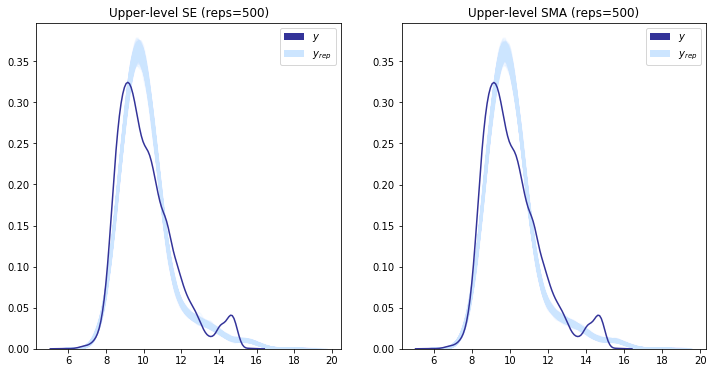

In [67]:
f